# Compute the atom centered Coulomb Matrix representation

To install QML library and compare rascal results with it
+ pip install qml ase

To install rascal:
+ mkdir ../build 
+ cd build
+ cmake -DCMAKE_BUILD_TYPE=Release -DBUILD_TESTS=ON ..
+ make -j 4
+ make install

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
import qml
from ase.io import read
from ase.visualize import view
import numpy as np
import sys

In [4]:
p = '/local/git/librascal/'
sys.path.insert(0,p+'build/')

In [5]:
from rascal.representation import SortedCoulombMatrix

In [6]:
# load a small subset of structures from QM9
frames = read(p+'tests/reference_data/dft-smiles_500.xyz',':')
cutoff = 3.
rep = SortedCoulombMatrix(cutoff,sort='rownorm')

In [7]:
# have a look at them
#view(frames)

In [16]:
# Compute the sorted coulomb matrices for the list of structures
%timeit -n 20 -r 5 features = rep.transform(frames)

97.3 ms ± 386 µs per loop (mean ± std. dev. of 5 runs, 20 loops each)


In [12]:
# extract the feature matrix to compare with 
test = features.get_feature_matrix().T

In [13]:
features.shape()

(8977, 276)

In [14]:
# To get the coulomb matrices from QML
def get_coulomb_ref(frame,size,cutoff,flavour):
    from qml.representations import generate_atomic_coulomb_matrix
    
    nuclear_charges = frame.get_atomic_numbers()
    coordinates = frame.get_positions()
    
    
    cm = generate_atomic_coulomb_matrix(nuclear_charges, coordinates, size = size, sorting = flavour,
    central_cutoff = cutoff, central_decay = -1, interaction_cutoff = 1e6, interaction_decay = -1,indices = None)
    
    return cm
def get_coulomb_refs(frames,size,cutoff,flavour='distance'):  
    cms = []
    for frame in frames:
        cms.append(get_coulomb_ref(frame,size,cutoff,flavour))
    return np.vstack(cms)

In [17]:
# Compare with reference
%timeit -n 20 -r 5 ref = get_coulomb_refs(frames,rep.size,cutoff,flavour='row-norm')
np.allclose(test,ref)

35.7 ms ± 318 µs per loop (mean ± std. dev. of 5 runs, 20 loops each)


True

In [13]:
from rascal.utils import fps

In [14]:
sparse_indices,sparse_minmax_d2 = fps(test,Nselect=500,starting_index=None,flavour='simple')

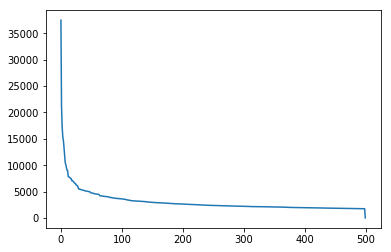

In [15]:
plt.plot(sparse_minmax_d2)